<div style="border-radius:10px;
            border:#0b0265 solid;
           background-color:#85e0e0;
           font-size:110%;
           letter-spacing:0.5px;
            text-align: center">

<center><h1 style="padding: 25px 0px; color:#0b0265; font-weight: bold; font-family: Cursive">
Customer Segmentation (Clustering) </h1></center>    

</div>

**Customer Personality Analysis** is a detailed analysis of a company’s ideal customers. It helps a business to better understand its customers and makes it easier for them to modify products according to the specific needs, behaviors and concerns of different types of customers.

Customer personality analysis helps a business to modify its product based on its target customers from different types of customer segments. For example, instead of spending money to market a new product to every customer in the company’s database, a company can analyze which customer segment is most likely to buy the product and then market the product only on that particular segment.

**Import Libraries and Data**

In [ ]:
# handle table-like data and matrices
import pandas as pd
import numpy as np

# visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

# preprocessing
from sklearn.preprocessing import StandardScaler

# pca
from sklearn.decomposition import PCA

# clustering
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans, AgglomerativeClustering

# evaluations
from sklearn.metrics import confusion_matrix

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# to display the total number columns present in the dataset
pd.set_option('display.max_columns', None)

In [ ]:
data = pd.read_csv('marketing_campaign.csv', sep="\t")

**Handling Missing Values**

let's find if we have missing values in the dataset.

In [ ]:
data.isnull().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

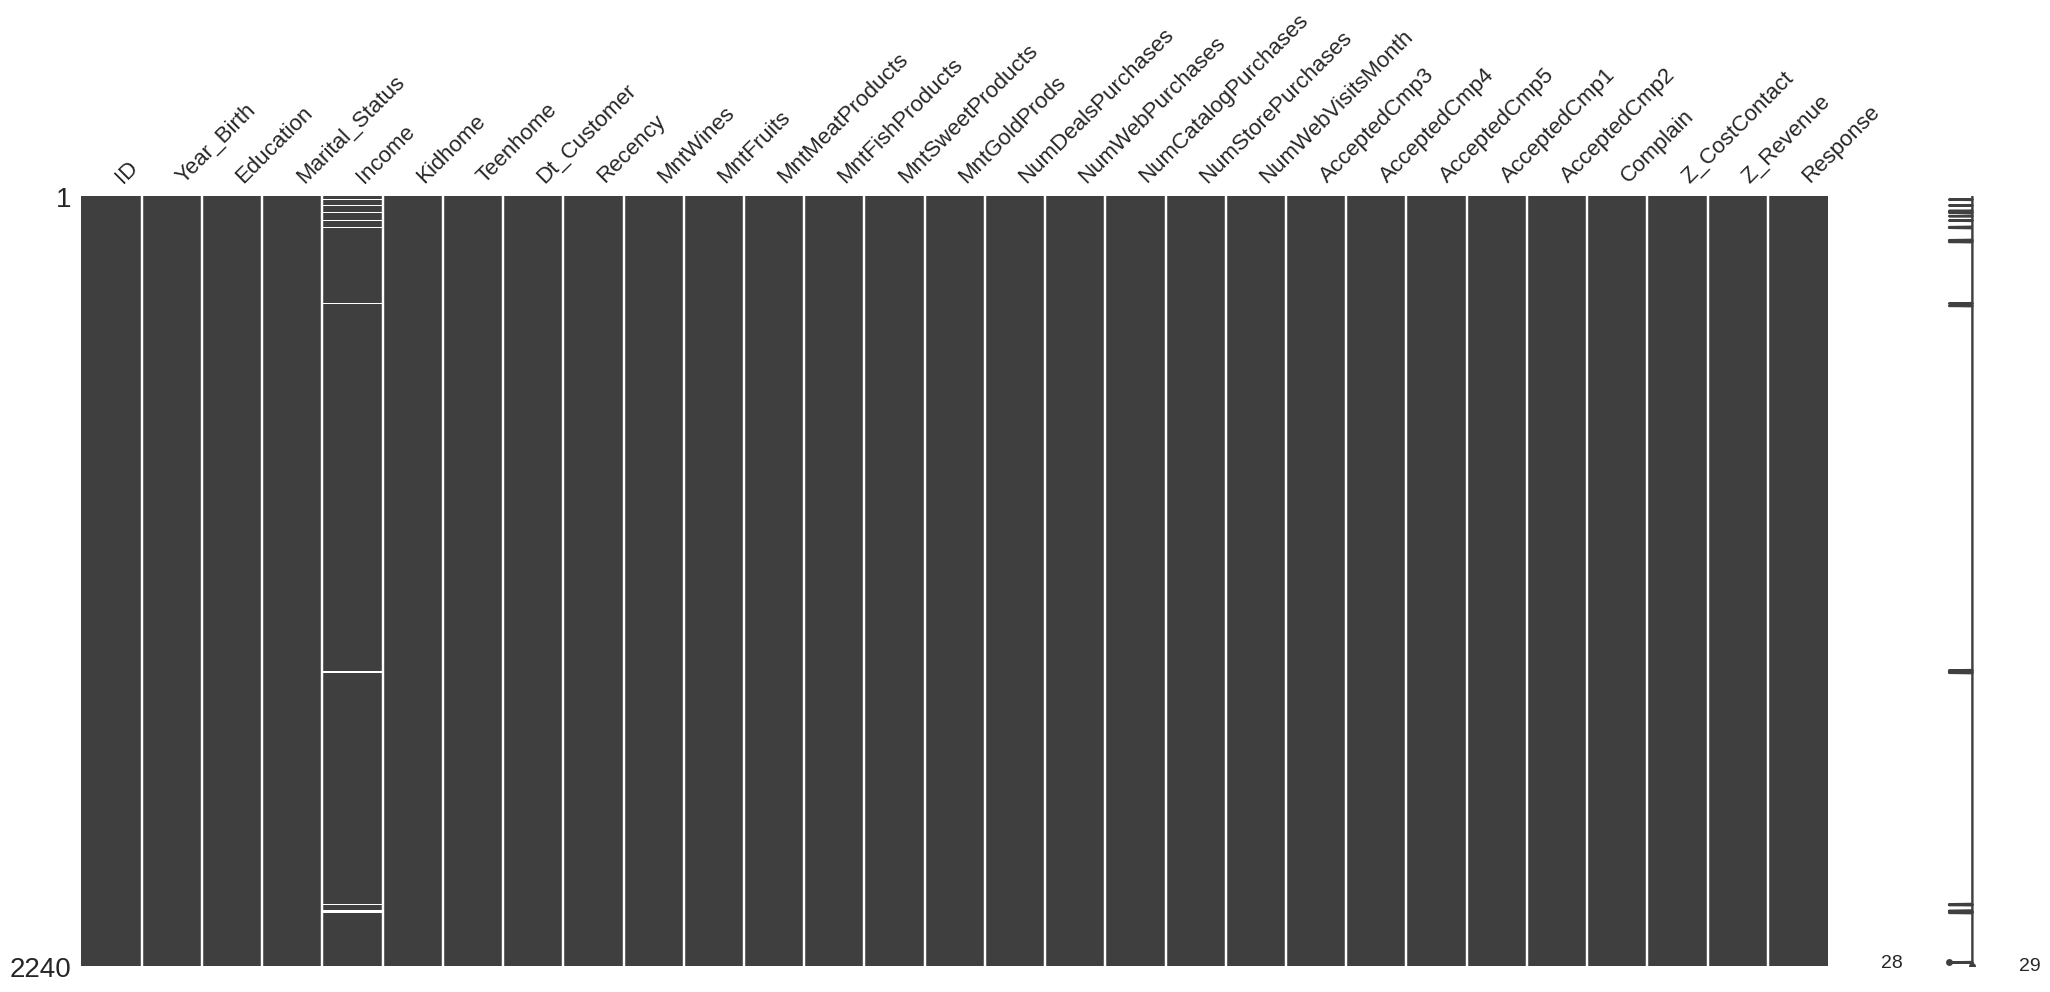

In [ ]:
msno.matrix(data);
#Visually represent missing values in a dataset as a matrix.
#White lines indicate missing values.
#Black lines indicate non-missing values.

In [ ]:
data = data.dropna()

In [ ]:
data.isnull().sum()

ID                     0
Year_Birth             0
Education              0
Marital_Status         0
Income                 0
Kidhome                0
Teenhome               0
Dt_Customer            0
Recency                0
MntWines               0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
MntSweetProducts       0
MntGoldProds           0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
AcceptedCmp3           0
AcceptedCmp4           0
AcceptedCmp5           0
AcceptedCmp1           0
AcceptedCmp2           0
Complain               0
Z_CostContact          0
Z_Revenue              0
Response               0
dtype: int64

let's find if we have duplicate rows.

In [ ]:
data.duplicated().sum()

0

**Feature Engineering**

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2216 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2216 non-null   int64  
 1   Year_Birth           2216 non-null   int64  
 2   Education            2216 non-null   object 
 3   Marital_Status       2216 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2216 non-null   int64  
 6   Teenhome             2216 non-null   int64  
 7   Dt_Customer          2216 non-null   object 
 8   Recency              2216 non-null   int64  
 9   MntWines             2216 non-null   int64  
 10  MntFruits            2216 non-null   int64  
 11  MntMeatProducts      2216 non-null   int64  
 12  MntFishProducts      2216 non-null   int64  
 13  MntSweetProducts     2216 non-null   int64  
 14  MntGoldProds         2216 non-null   int64  
 15  NumDealsPurchases    2216 non-null   int64 

Dt_Customer that indicates the date a customer joined the database is not parsed as DateTime

In [ ]:
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'], format="%d-%m-%Y")

In [ ]:
print("The newest customer's enrolment date in the records:", max(data['Dt_Customer']))
print("The oldest customer's enrolment date in the records:", min(data['Dt_Customer']))

The newest customer's enrolment date in the records: 2014-06-29 00:00:00
The oldest customer's enrolment date in the records: 2012-07-30 00:00:00


Extract the "Age" of a customer by the "Year_Birth" indicating the birth year of the respective person.

In [ ]:
data['Age'] = 2015 - data['Year_Birth']

Create another feature "Spent" indicating the total amount spent by the customer in various categories over the span of two years.

In [ ]:
data['Spent'] = data['MntWines'] + data['MntFruits'] + data['MntMeatProducts'] + data['MntFishProducts'] + data['MntSweetProducts'] + data['MntGoldProds']

Create another feature "Living_With" out of "Marital_Status" to extract the living situation of couples.

In [ ]:
data['Living_With'] = data['Marital_Status'].replace({'Married':'Partner', 'Together':'Partner', 'Absurd':'Alone', 'Widow':'Alone', 'YOLO':'Alone', 'Divorced':'Alone', 'Single':'Alone'})

Create a feature "Children" to indicate total children in a household that is, kids and teenagers.

In [ ]:
data['Children'] = data['Kidhome'] + data['Teenhome']

To get further clarity of household, Creating feature indicating "Family_Size"

In [ ]:
data['Family_Size'] = data['Living_With'].replace({'Alone': 1, 'Partner':2}) + data['Children']

Create a feature "Is_Parent" to indicate parenthood status

In [ ]:
data['Is_Parent'] = np.where(data.Children > 0, 1, 0)

Segmenting education levels in three groups

In [ ]:
data['Education'] = data['Education'].replace({'Basic':'Undergraduate', '2n Cycle':'Undergraduate', 'Graduation':'Graduate', 'Master':'Postgraduate', 'PhD':'Postgraduate'})

Dropping some of the redundant features

In [ ]:
to_drop = ['Marital_Status', 'Dt_Customer', 'Z_CostContact', 'Z_Revenue', 'Year_Birth', 'ID']
data = data.drop(to_drop, axis=1)

In [ ]:
data.head(3)

,Education,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,Graduate,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,58,1617,Alone,0,1,0
1,Graduate,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,61,27,Alone,2,3,1
2,Graduate,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,50,776,Partner,0,2,0


**Data Analysis and Visualization**

In [ ]:
data.shape

(2216, 29)

There are 2216 cutomers and 29 features in the dataset.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2216 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2216 non-null   object 
 1   Income               2216 non-null   float64
 2   Kidhome              2216 non-null   int64  
 3   Teenhome             2216 non-null   int64  
 4   Recency              2216 non-null   int64  
 5   MntWines             2216 non-null   int64  
 6   MntFruits            2216 non-null   int64  
 7   MntMeatProducts      2216 non-null   int64  
 8   MntFishProducts      2216 non-null   int64  
 9   MntSweetProducts     2216 non-null   int64  
 10  MntGoldProds         2216 non-null   int64  
 11  NumDealsPurchases    2216 non-null   int64  
 12  NumWebPurchases      2216 non-null   int64  
 13  NumCatalogPurchases  2216 non-null   int64  
 14  NumStorePurchases    2216 non-null   int64  
 15  NumWebVisitsMonth    2216 non-null   int64 

In [ ]:
data.describe()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Spent,Children,Family_Size,Is_Parent
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,2.323556,4.085289,2.671029,5.800993,5.319043,0.073556,0.074007,0.073105,0.064079,0.013538,0.009477,0.150271,46.179603,607.075361,0.947202,2.592509,0.714350
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,1.923716,2.740951,2.926734,3.250785,2.425359,0.261106,0.261842,0.260367,0.244950,0.115588,0.096907,0.357417,11.985554,602.900476,0.749062,0.905722,0.451825
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000,5.000000,0.000000,1.000000,0.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,38.000000,69.000000,0.000000,2.000000,0.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,45.000000,396.500000,1.000000,3.000000,1.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,56.000000,1048.000000,1.000000,3.000000,1.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,122.000000,2525.000000,3.000000,5.000000,1.000000


In [ ]:
data.describe(include=object).T

,count,unique,top,freq
Education,2216,3,Graduate,1116
Living_With,2216,2,Partner,1430


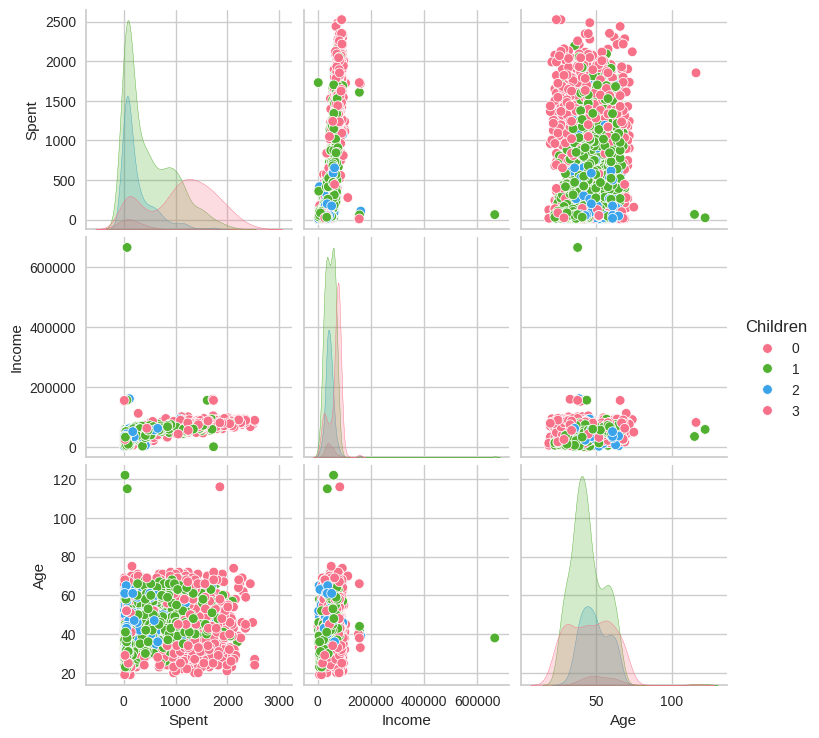

In [ ]:
sns.pairplot(data , vars=['Spent','Income','Age'] , hue='Children', palette='husl');

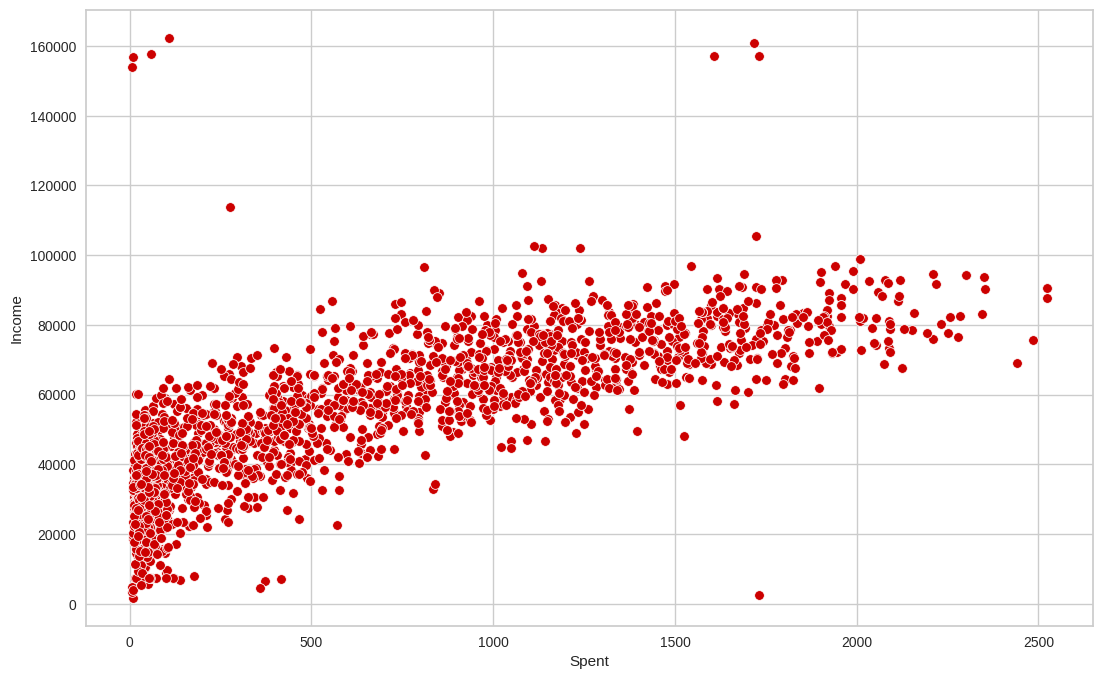

In [ ]:
plt.figure(figsize=(13,8))
sns.scatterplot(x=data[data['Income']<600000]['Spent'], y=data[data['Income']<600000]['Income'], color='#cc0000');

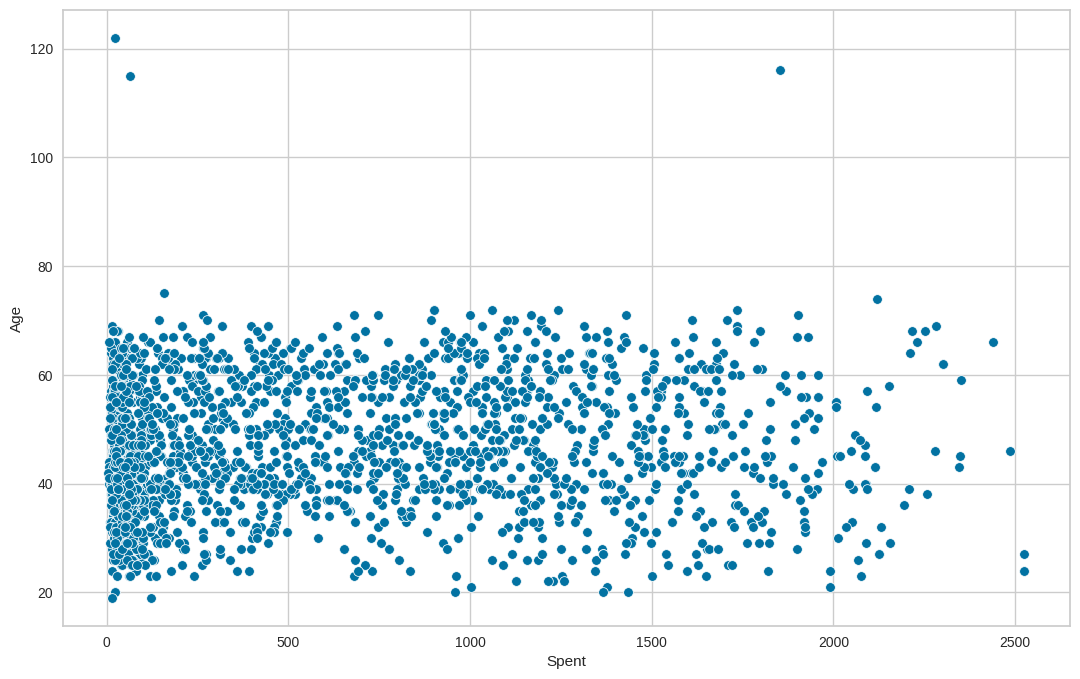

In [ ]:
plt.figure(figsize=(13,8))
sns.scatterplot(x=data['Spent'], y=data['Age']);

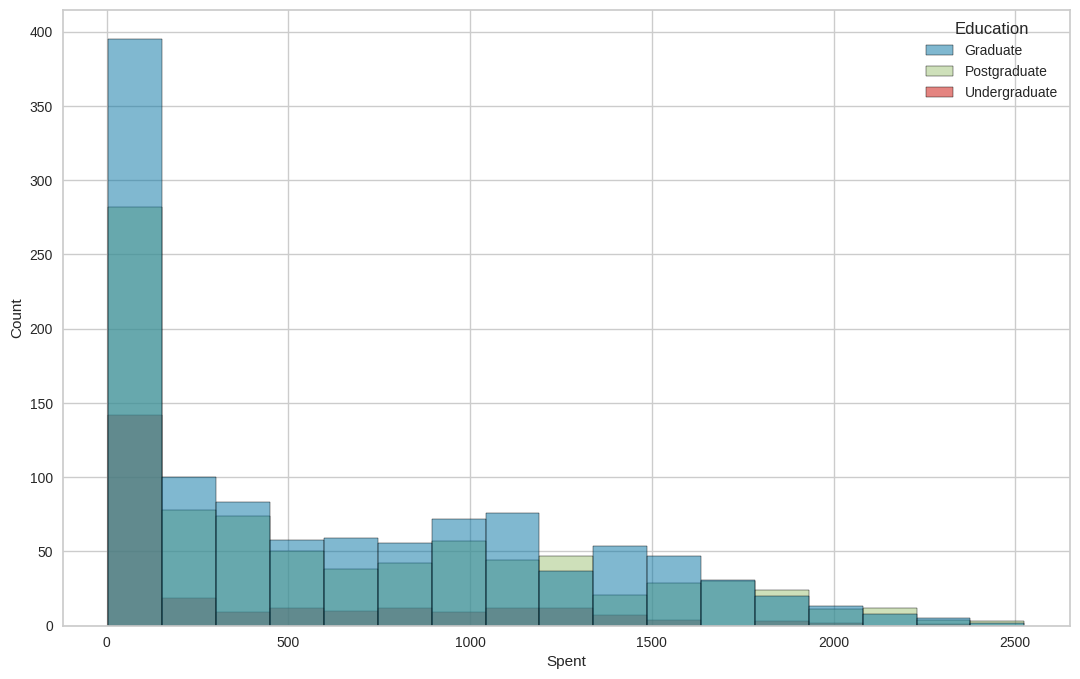

In [ ]:
plt.figure(figsize=(13,8))
sns.histplot(x=data['Spent'], hue=data['Education']);

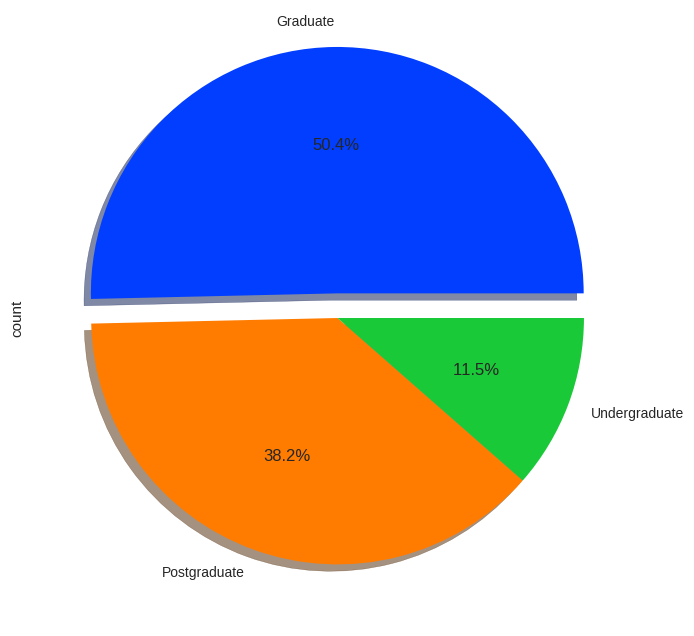

In [ ]:
data['Education'].value_counts().plot.pie(explode=[0.1,0,0], autopct='%1.1f%%', shadow=True, figsize=(8,8), colors=sns.color_palette('bright'));

**Outlier Detection**

The presence of outliers in a classification or regression dataset can result in a poor fit and lower predictive modeling performance, therefore we should see there are ouliers in the data.

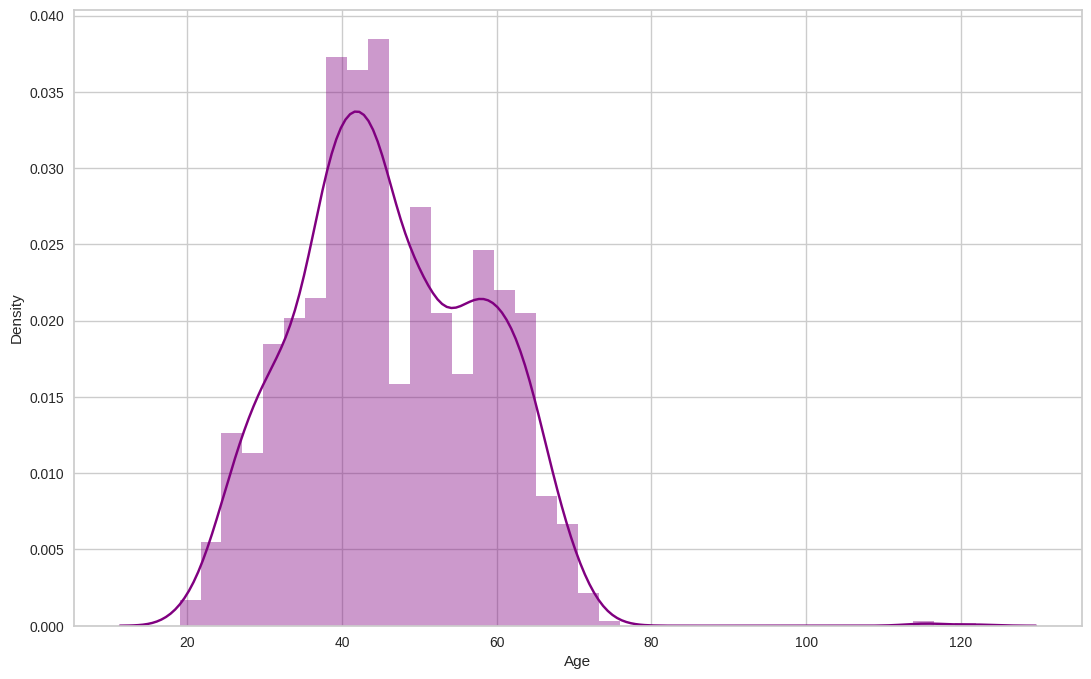

In [ ]:
plt.figure(figsize=(13,8))
sns.distplot(data.Age, color='purple');

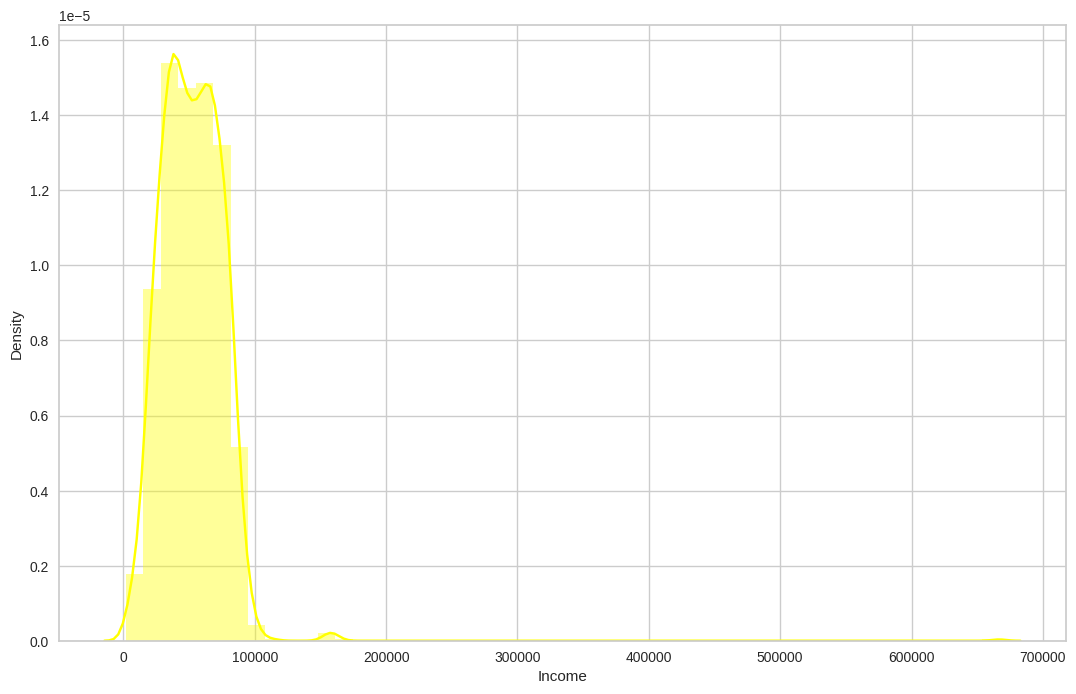

In [ ]:
plt.figure(figsize=(13,8))
sns.distplot(data.Income, color='Yellow');

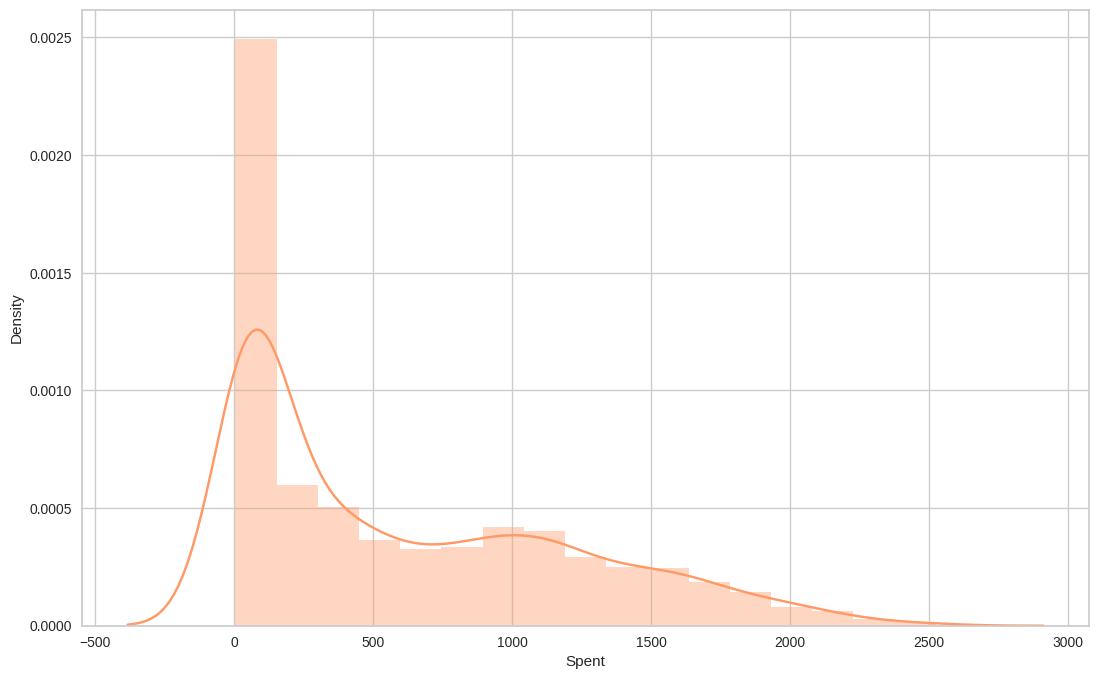

In [ ]:
plt.figure(figsize=(13,8))
sns.distplot(data.Spent, color='#ff9966');

Another way of visualising outliers is using boxplots and whiskers,
which provides the quantiles (box) and inter-quantile range (whiskers),
with the outliers sitting outside the error bars (whiskers).

All the dots in the plot below are outliers according to the quantiles + 1.5 IQR rule

In [ ]:
fig = make_subplots(rows=1, cols=3)

fig.add_trace(go.Box(y=data['Age'], notched=True, name='Age', marker_color = '#6699ff',
                     boxmean=True, boxpoints='suspectedoutliers'), 1, 2)

fig.add_trace(go.Box(y=data['Income'], notched=True, name='Income', marker_color = '#ff0066',
                     boxmean=True, boxpoints='suspectedoutliers'), 1, 1)

fig.add_trace(go.Box(y=data['Spent'], notched=True, name='Spent', marker_color = 'lightseagreen',
                     boxmean=True, boxpoints='suspectedoutliers'), 1, 3)

fig.update_layout(title_text='<b>Box Plots for Numerical Variables<b>')

fig.show()

<p align="center">
  <img width="600" height="300" src="https://miro.medium.com/proxy/1*ghJQrcLZXGWxDPzppLWULA.png">
</p>

In [ ]:
data.head(1)

,Education,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,Graduate,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,58,1617,Alone,0,1,0


In [ ]:
numerical = ['Income', 'Recency', 'Age', 'Spent']

In [ ]:
def detect_outliers(d):
  for i in d:
    Q3, Q1 = np.percentile(data[i], [75 ,25])
    IQR = Q3 - Q1

    ul = Q3+1.5*IQR
    ll = Q1-1.5*IQR

    outliers = data[i][(data[i] > ul) | (data[i] < ll)]
    print(f'*** {i} outlier points***', '\n', outliers, '\n')

In [ ]:
detect_outliers(numerical)

*** Income outlier points*** 
 164     157243.0
617     162397.0
655     153924.0
687     160803.0
1300    157733.0
1653    157146.0
2132    156924.0
2233    666666.0
Name: Income, dtype: float64 

*** Recency outlier points*** 
 Series([], Name: Recency, dtype: int64) 

*** Age outlier points*** 
 192    115
239    122
339    116
Name: Age, dtype: int64 

*** Spent outlier points*** 
 1179    2525
1492    2524
1572    2525
Name: Spent, dtype: int64 



We will delete some of the outlier points.

In [ ]:
data = data[(data['Age']<100)]
data = data[(data['Income']<600000)]

In [ ]:
data.shape

(2212, 29)

**Check for Rare Categories**

Some categories may appear a lot in the dataset, whereas some other categories appear only in a few number of observations.

* Rare values in categorical variables tend to cause over-fitting, particularly in tree based methods.
* Rare labels may be present in training set, but not in test set, therefore causing over-fitting to the train set.
* Rare labels may appear in the test set, and not in the train set. Thus, the machine learning model will not know how to evaluate it.

In [ ]:
categorical = [var for var in data.columns if data[var].dtype=='O']

In [ ]:
# check the number of different labels
for var in categorical:
    print(data[var].value_counts() / np.float64(len(data)))
    print()
    print()

Education
Graduate         0.504069
Postgraduate     0.382007
Undergraduate    0.113924
Name: count, dtype: float64


Living_With
Partner    0.64557
Alone      0.35443
Name: count, dtype: float64




As shown above, there is no rare category in the categorical variables.

**Categorical Variables Encoding**

In [ ]:
categorical

['Education', 'Living_With']

In [ ]:
data['Living_With'].unique()

array(['Alone', 'Partner'], dtype=object)

Since the education is a ordinal variable, we will encode it with ordinal numbers.

In [ ]:
data['Education'] = data['Education'].map({'Undergraduate':0,'Graduate':1, 'Postgraduate':2})

In [ ]:
data['Living_With'] = data['Living_With'].map({'Alone':0,'Partner':1})

In [ ]:
data.dtypes

Education                int64
Income                 float64
Kidhome                  int64
Teenhome                 int64
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3             int64
AcceptedCmp4             int64
AcceptedCmp5             int64
AcceptedCmp1             int64
AcceptedCmp2             int64
Complain                 int64
Response                 int64
Age                      int64
Spent                    int64
Living_With              int64
Children                 int64
Family_Size              int64
Is_Parent                int64
dtype: object

In [ ]:
data.head(3)

,Education,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,1,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,58,1617,0,0,1,0
1,1,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,61,27,0,2,3,1
2,1,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,50,776,1,0,2,0


**Feature Scaling**

In this section, numerical features are scaled.

StandardScaler = $\frac{x-\mu}{s}$

In [ ]:
data_old = data.copy()

In [ ]:
# creating a subset of dataframe by dropping the features on deals accepted and promotions
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
data = data.drop(cols_del, axis=1)

In [ ]:
scaler = StandardScaler()
data = pd.DataFrame(scaler.fit_transform(data), columns = data.columns)

In [ ]:
data.head(3)

,Education,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,-0.411675,0.287105,-0.822754,-0.929699,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,0.852576,0.351030,1.426865,2.503607,-0.555814,0.692181,1.018352,1.676245,-1.349603,-1.264598,-1.758359,-1.581139
1,-0.411675,-0.260882,1.040021,0.908097,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,-0.733642,-0.168701,-1.126420,-0.571340,-1.171160,-0.132545,1.274785,-0.963297,-1.349603,1.404572,0.449070,0.632456
2,-0.411675,0.913196,-0.822754,-0.929699,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,-0.037254,-0.688432,1.426865,-0.229679,1.290224,-0.544908,0.334530,0.280110,0.740959,-1.264598,-0.654644,-1.581139


**Dimensionality Reduction**

In [ ]:
p = PCA(n_components=3)
p.fit(data)

PCA(n_components=3)

In [ ]:
W = p.components_.T
W

array([[ 1.13473253e-02,  1.40725368e-01, -5.06924641e-01],
       [ 2.79487047e-01,  1.78231967e-01, -7.51920694e-02],
       [-2.46222754e-01,  5.22594957e-03,  2.82835709e-01],
       [-9.87088123e-02,  4.62104474e-01, -1.51354101e-01],
       [ 3.52657547e-03,  1.62572658e-02,  3.59324529e-02],
       [ 2.55717028e-01,  2.09381278e-01, -1.16490973e-01],
       [ 2.38397851e-01,  1.10596235e-02,  2.54313798e-01],
       [ 2.85462096e-01,  9.91842533e-03,  7.62462593e-02],
       [ 2.48709837e-01,  2.47881127e-04,  2.53735926e-01],
       [ 2.37301814e-01,  2.16349626e-02,  2.57577981e-01],
       [ 1.88380391e-01,  1.23087018e-01,  1.99502232e-01],
       [-7.82599013e-02,  3.48749545e-01,  1.51403812e-01],
       [ 1.67559688e-01,  2.96773080e-01,  2.34503078e-02],
       [ 2.77349124e-01,  1.05962114e-01,  1.68810194e-02],
       [ 2.41542878e-01,  2.05476670e-01, -7.68095769e-03],
       [-2.25949464e-01,  4.61005988e-02,  9.11392446e-02],
       [ 3.84647636e-02,  2.34787566e-01

In [ ]:
pd.DataFrame(W, index=data.columns, columns=['W1','W2','W3'])

,W1,W2,W3
Education,0.011347,0.140725,-0.506925
Income,0.279487,0.178232,-0.075192
Kidhome,-0.246223,0.005226,0.282836
Teenhome,-0.098709,0.462104,-0.151354
Recency,0.003527,0.016257,0.035932
MntWines,0.255717,0.209381,-0.116491
MntFruits,0.238398,0.011060,0.254314
MntMeatProducts,0.285462,0.009918,0.076246
MntFishProducts,0.248710,0.000248,0.253736
MntSweetProducts,0.237302,0.021635,0.257578


In [ ]:
p.explained_variance_

array([8.27465625, 2.9209145 , 1.43060258])

In [ ]:
p.explained_variance_ratio_

array([0.3759507 , 0.13270882, 0.06499799])

In [ ]:
pd.DataFrame(p.explained_variance_ratio_, index=range(1,4), columns=['Explained Variability'])

,Explained Variability
1,0.375951
2,0.132709
3,0.064998


In [ ]:
p.explained_variance_ratio_.cumsum()

array([0.3759507 , 0.50865952, 0.57365751])

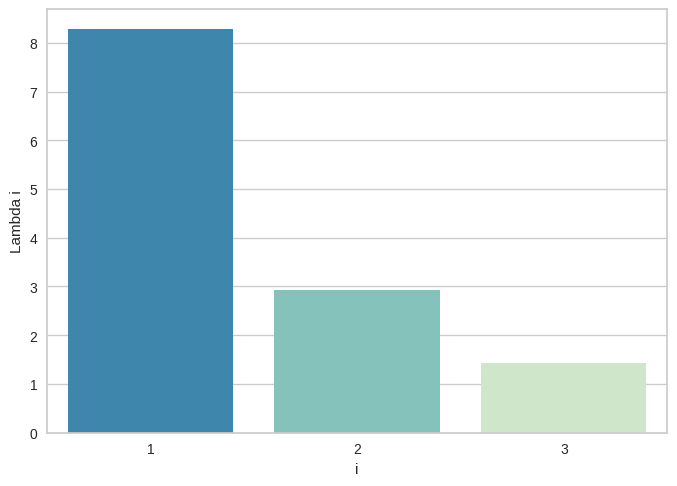

In [ ]:
sns.barplot(x = list(range(1,4)), y = p.explained_variance_, palette = 'GnBu_r')
plt.xlabel('i')
plt.ylabel('Lambda i');

In [ ]:
data_PCA = pd.DataFrame(p.transform(data), columns=(['col1', 'col2', 'col3']))

In [ ]:
data_PCA.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,2212.0,0.000000e+00,2.876570,-5.915029,-2.548037,-0.784932,2.418554,7.441146
col2,2212.0,-1.284887e-17,1.709068,-4.398440,-1.343431,-0.133328,1.243049,6.248176
col3,2212.0,1.284887e-17,1.196079,-3.544207,-0.865353,-0.014585,0.824499,5.030965


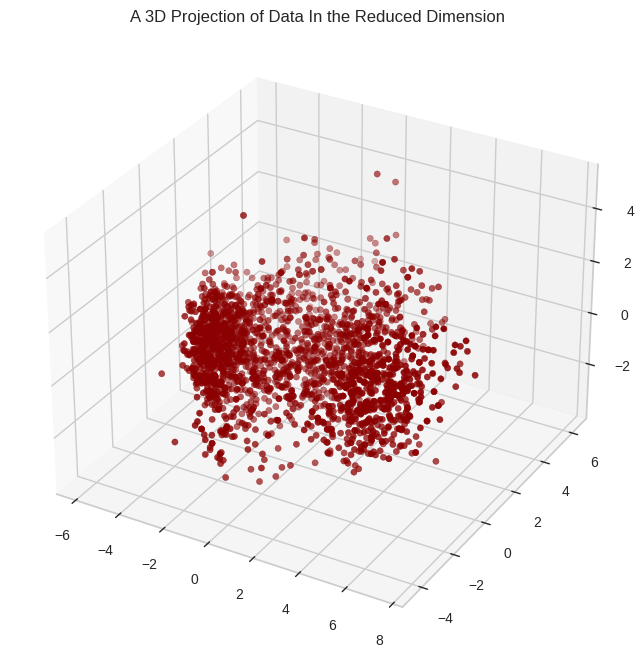

In [ ]:
x = data_PCA['col1']
y = data_PCA['col2']
z = data_PCA['col3']

fig = plt.figure(figsize=(13,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x,y,z, c='darkred', marker='o')
ax.set_title('A 3D Projection of Data In the Reduced Dimension')
plt.show()

**Clustering**

Elbow Method to determine the number of clusters to be formed.

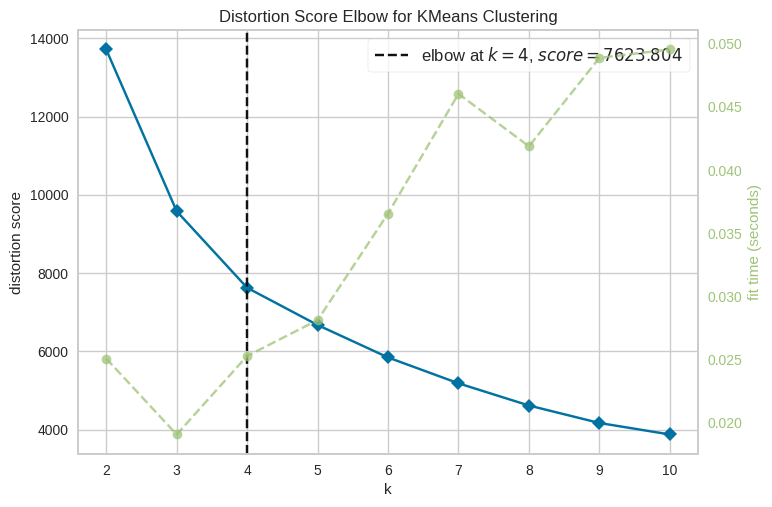

In [ ]:
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(data_PCA)
Elbow_M.show();

In [ ]:
AC = AgglomerativeClustering(n_clusters=4)
# fit model and predict clusters
yhat_AC = AC.fit_predict(data_PCA)
data_PCA['Clusters'] = yhat_AC
#Adding the Clusters feature to the orignal dataframe.
data['Clusters'] = yhat_AC
data_old['Clusters'] = yhat_AC

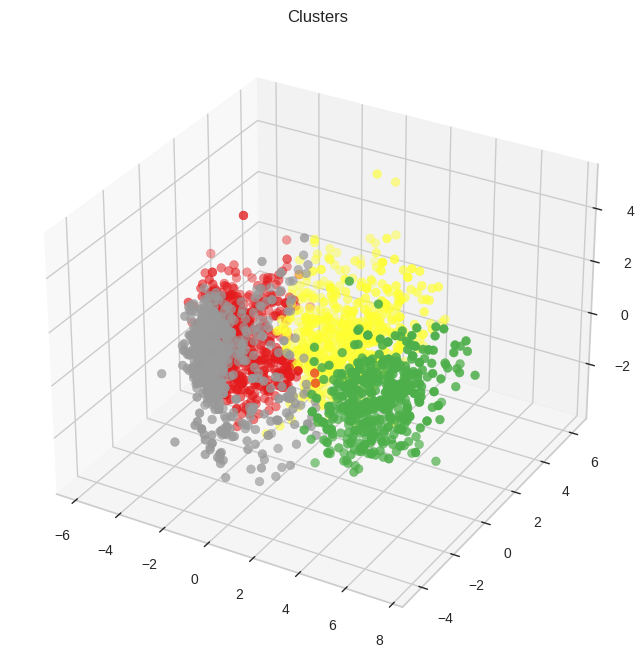

In [ ]:
fig = plt.figure(figsize=(13,8))
ax = plt.subplot(111, projection='3d', label='bla')
ax.scatter(x, y, z, s=40, c=data_PCA['Clusters'], marker='o', cmap='Set1_r')
ax.set_title('Clusters')
plt.show()



**Clusters Analysis and Customers Profiling**

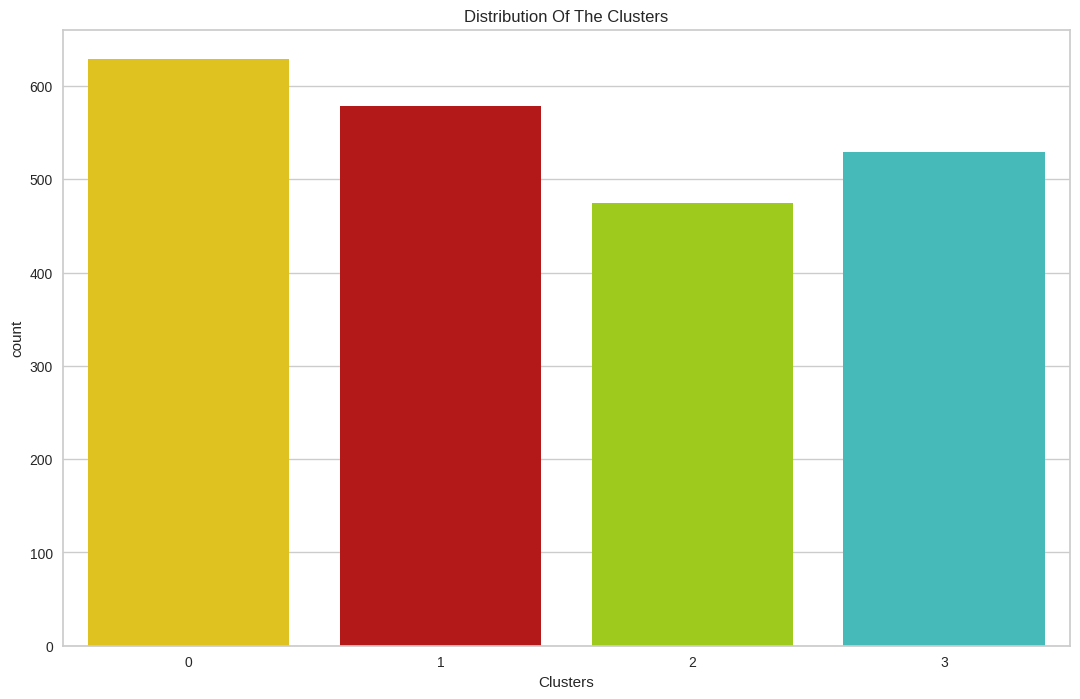

In [ ]:
pal = ['gold','#cc0000', '#ace600','#33cccc']
plt.figure(figsize=(13,8))
pl = sns.countplot(x=data['Clusters'], palette= pal)
pl.set_title('Distribution Of The Clusters')
plt.show()

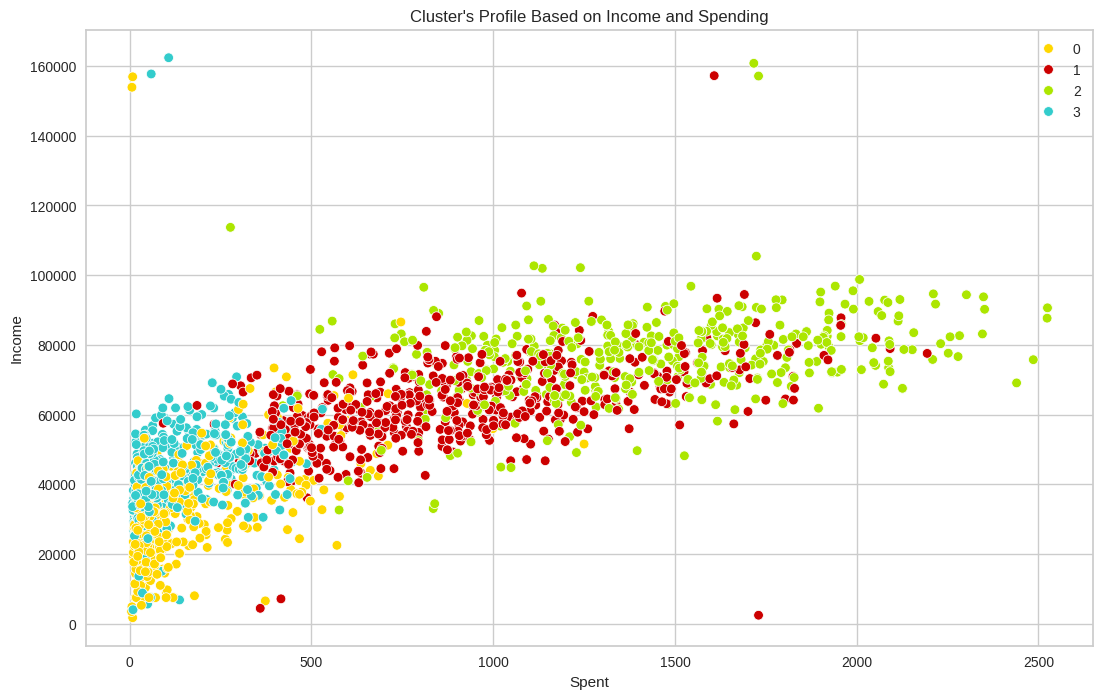

In [ ]:
plt.figure(figsize=(13,8))
pl = sns.scatterplot(data=data_old, x=data_old['Spent'], y=data_old['Income'], hue=data_old['Clusters'], palette= pal)
pl.set_title("Cluster's Profile Based on Income and Spending")
plt.legend();

Income vs spending plot shows the clusters pattern

* group 1: high spending & average income
* group 0: low spending & low income
* group 3: low spending & average income
* group 2: high spending & high income

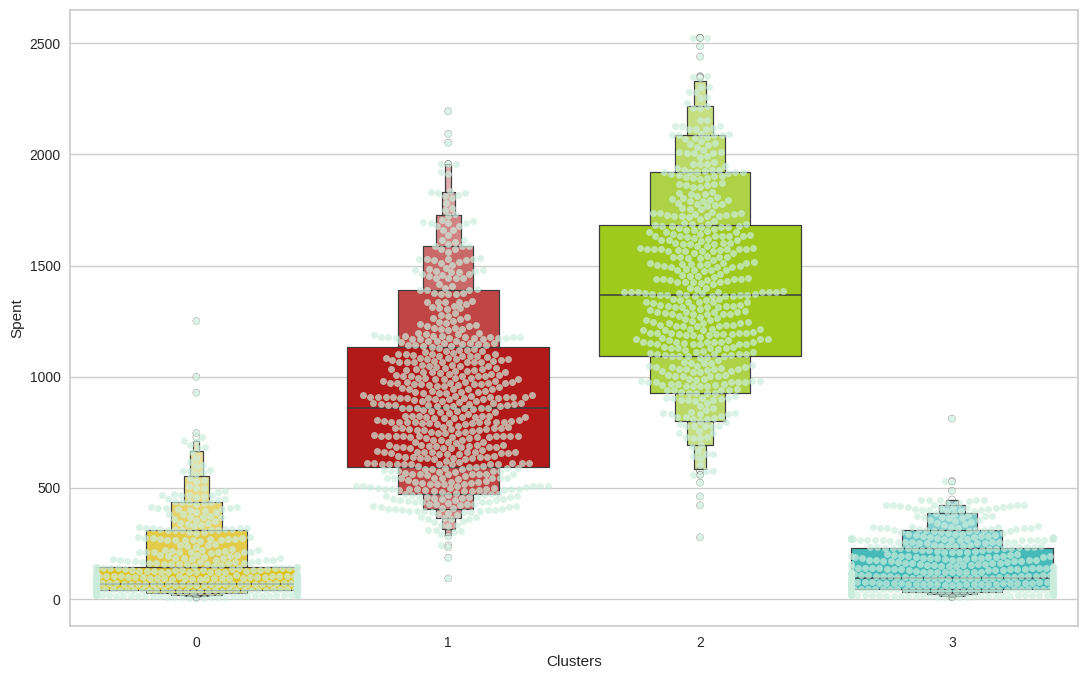

In [ ]:
plt.figure(figsize=(13,8))
pl = sns.swarmplot(x=data_old['Clusters'], y=data_old['Spent'], color="#CBEDDD", alpha=0.7)
pl = sns.boxenplot(x=data_old['Clusters'], y=data_old['Spent'], palette=pal)
plt.show();

From the above plot, it can be clearly seen that cluster 2 is our biggest set of customers closely followed by cluster 1. We can explore what each cluster is spending on for the targeted marketing strategies.

Plotting count of total campaign accepted.

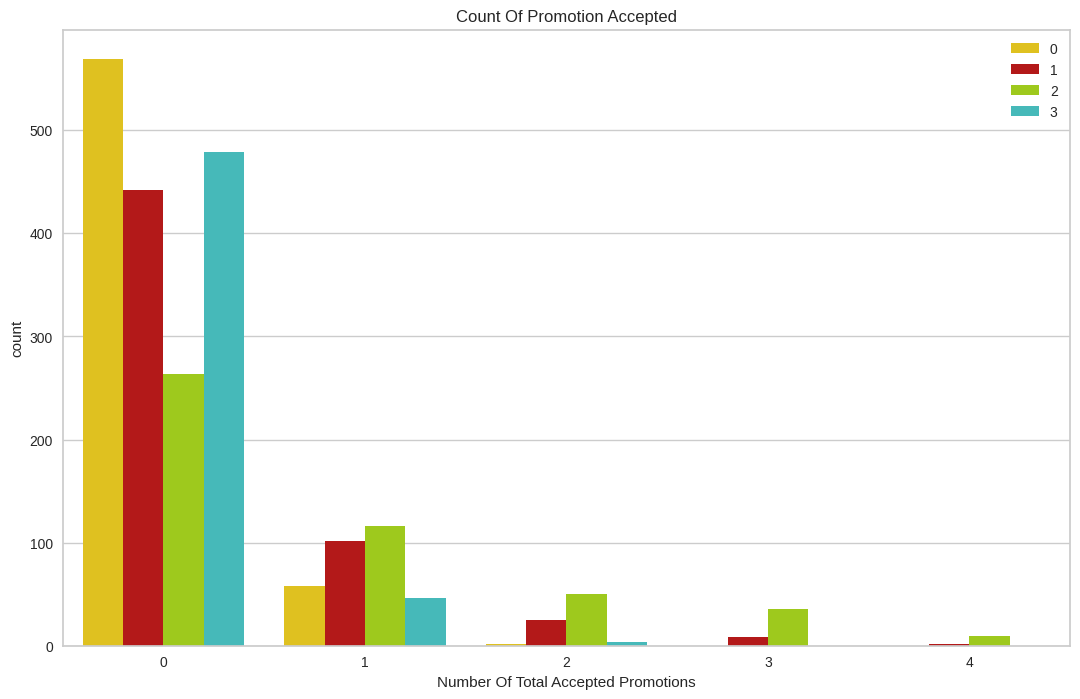

In [ ]:
data_old['Total_Promos'] = data_old['AcceptedCmp1']+ data_old['AcceptedCmp2']+ data_old['AcceptedCmp3']+ data_old['AcceptedCmp4']+ data_old['AcceptedCmp5']

plt.figure(figsize=(13,8))
pl = sns.countplot(x=data_old['Total_Promos'], hue=data_old['Clusters'], palette= pal)
pl.set_title('Count Of Promotion Accepted')
pl.set_xlabel('Number Of Total Accepted Promotions')
plt.legend(loc='upper right')
plt.show();

There has not been an overwhelming response to the campaigns so far. Very few participants overall. Moreover, no one part take in all 5 of them. Perhaps better-targeted and well-planned campaigns are required to boost sales.

Plotting the number of deals purchased

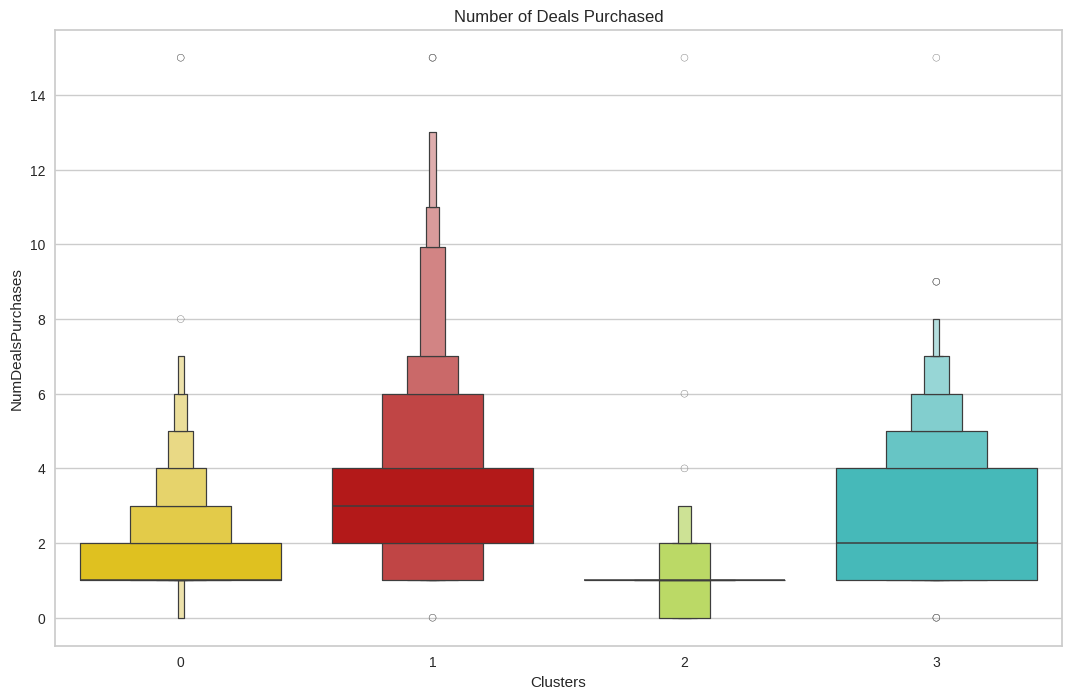

In [ ]:
plt.figure(figsize=(13,8))
pl=sns.boxenplot(y=data_old['NumDealsPurchases'],x=data_old['Clusters'], palette= pal)
pl.set_title('Number of Deals Purchased');

Unlike campaigns, the deals offered did well. It has best outcome with cluster 1 and cluster 3. However, our star customers cluster 2 are not much into the deals. Nothing seems to attract cluster 0 overwhelmingly

<Figure size 1300x800 with 0 Axes>

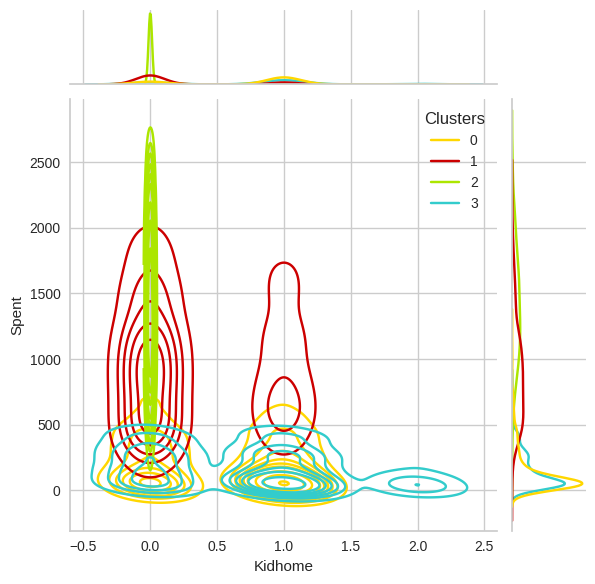

<Figure size 1300x800 with 0 Axes>

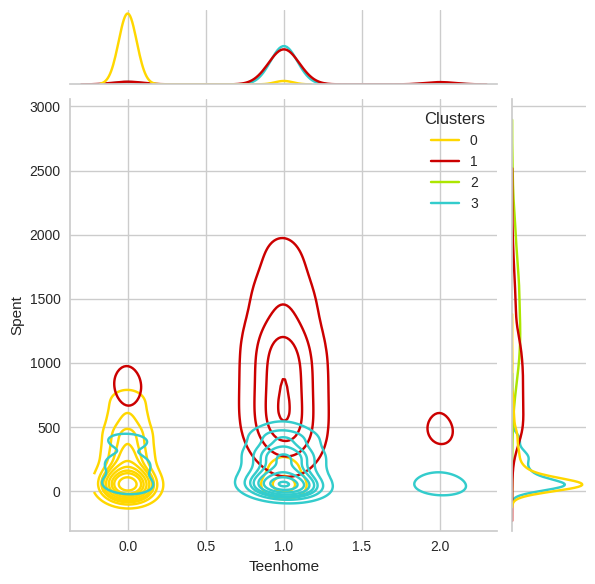

<Figure size 1300x800 with 0 Axes>

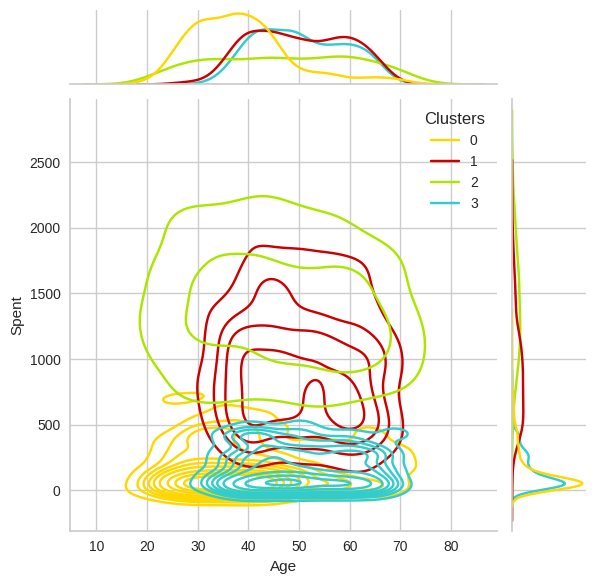

<Figure size 1300x800 with 0 Axes>

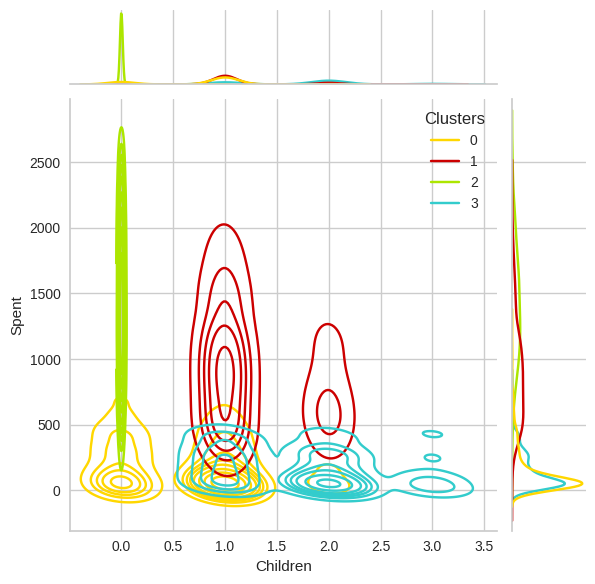

<Figure size 1300x800 with 0 Axes>

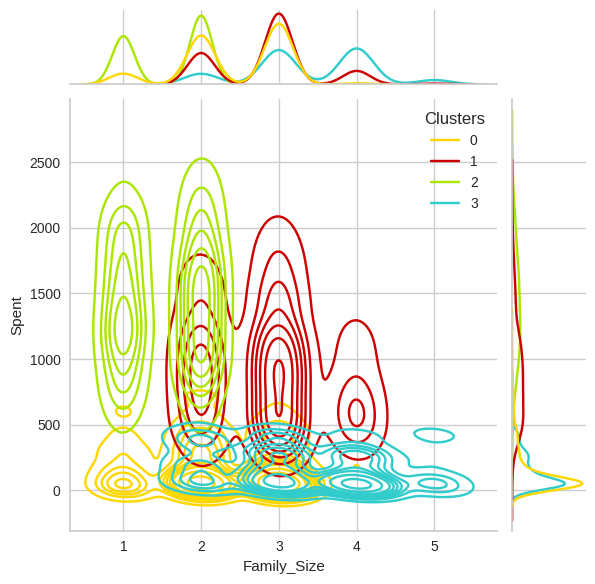

<Figure size 1300x800 with 0 Axes>

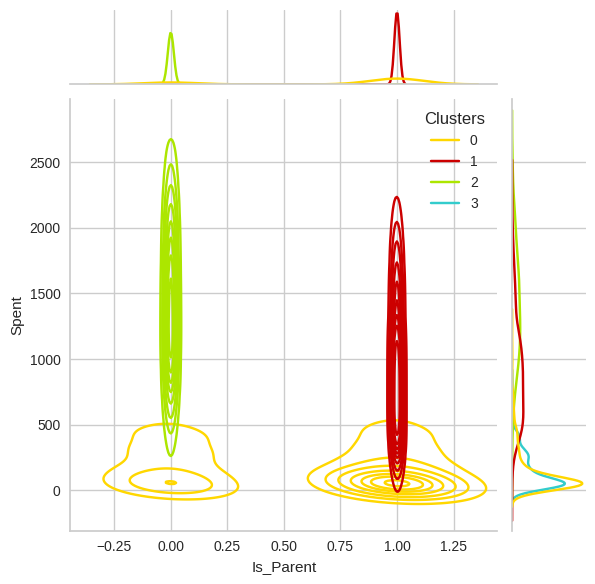

<Figure size 1300x800 with 0 Axes>

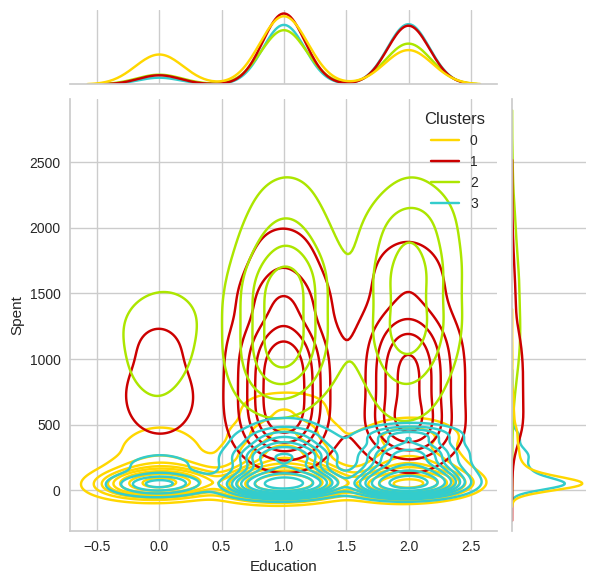

<Figure size 1300x800 with 0 Axes>

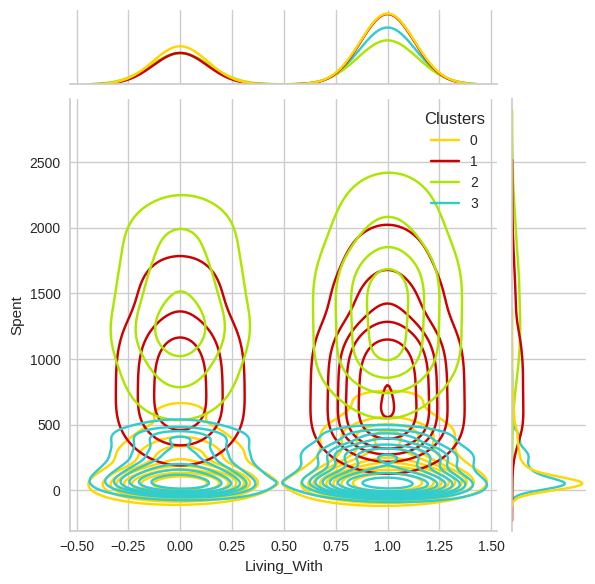

In [ ]:
Personal = ['Kidhome', 'Teenhome', 'Age', 'Children', 'Family_Size', 'Is_Parent', 'Education', 'Living_With']

for i in Personal:
    plt.figure(figsize=(13,8))
    sns.jointplot(x=data_old[i], y=data_old['Spent'], hue=data_old['Clusters'], kind='kde', palette=pal);

**About Cluster 0:**
* The majority of these people are parents
* At max have 3 members in the family
* They majorly have one kid and typically not tennagers
* Relatively younger

**About Cluster 1:**
* Definitely a parent
* At max have 4 members in the family and at least 2
* Most have a teeanger in home
* Single parents are a subset of this group
* Relatively older

**About Cluster 2:**
* Definitely not a parent
* At max are only 2 members in the family.
* A slight majority of couples over single people
* Span all ages
* high income and high spending

**About Cluster 3:**
* Definitely a parent
* At max have 5 members in the family and at least 2
* Majority of them have a teenager at home
* Relatively older